In [2]:
import pandas as pd

# Load the excel dataset into a pandas dataframe 
data = pd.read_excel("dataset.xlsx")
print(data.head())


          From Date           To Date   PM2.5    PM10     NO    NO2    NOx  \
0  19-02-2022 00:00  20-02-2022 00:00   94.22  206.05  38.05  52.75  59.14   
1  20-02-2022 00:00  21-02-2022 00:00   77.20  175.59   8.25  44.14  30.37   
2  21-02-2022 00:00  22-02-2022 00:00   85.19  219.39  65.20  52.64  81.44   
3  22-02-2022 00:00  23-02-2022 00:00  107.57  269.16  36.97  35.09  49.83   
4  23-02-2022 00:00  24-02-2022 00:00  113.24  208.93  15.29  26.74  26.95   

     NH3    SO2    CO  Ozone  
0  34.77  11.08  1.19  42.83  
1  28.73   9.78  1.38  60.86  
2  25.33   9.87  2.39  40.01  
3  37.96  14.06  1.33  79.56  
4  31.46   8.42  1.87  67.35  


In [3]:
# Drop dates column
data = data.drop(columns=["From Date", "To Date"])
data = data.dropna()
data = data.reset_index(drop=True)
data

,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone
0,94.22,206.05,38.05,52.75,59.14,34.77,11.08,1.19,42.83
1,77.20,175.59,8.25,44.14,30.37,28.73,9.78,1.38,60.86
2,85.19,219.39,65.20,52.64,81.44,25.33,9.87,2.39,40.01
3,107.57,269.16,36.97,35.09,49.83,37.96,14.06,1.33,79.56
4,113.24,208.93,15.29,26.74,26.95,31.46,8.42,1.87,67.35
...,...,...,...,...,...,...,...,...,...
701,87.31,254.65,38.42,44.76,55.05,40.82,9.02,1.06,32.64
702,90.57,258.18,47.37,46.83,63.43,40.72,7.26,1.16,27.39
703,108.45,309.15,124.05,53.31,129.21,47.38,9.09,1.31,30.74
704,76.97,259.44,8.02,40.00,27.80,45.97,8.15,0.51,49.84


In [4]:
# Time series forecasting using LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, data, test_size=0.2, random_state=42)



Epoch 1/100

18/18 [==============================] - 2s 18ms/step - loss: 0.1024 - val_loss: 0.0717
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0580 - val_loss: 0.0330
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0271 - val_loss: 0.0254
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0227 - val_loss: 0.0211
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0208 - val_loss: 0.0201
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 0.0190 - val_loss: 0.0181
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0174 - val_loss: 0.0170
Epoch 8/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0159 - val_loss: 0.0151
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0145 - val_loss: 0.0152
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0137 - val_loss: 0.0138
Epoch

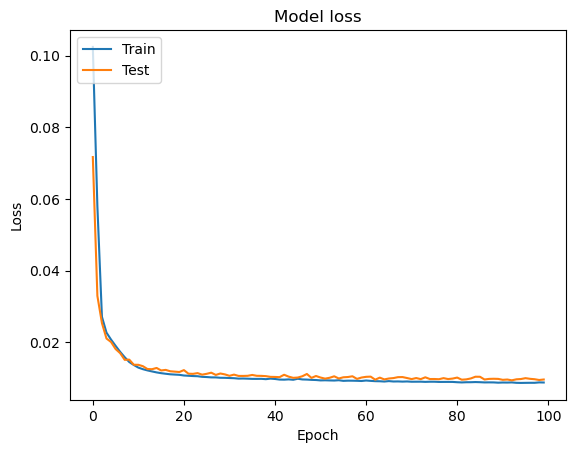

5/5 [==============================] - 0s 2ms/step
Train RMSE: 27.629557409260507
Test RMSE: 28.42052795750374


In [6]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Define the number of time steps
n_steps = 3
n_features = data.shape[1]

# Split the data into input features and target variable
X, y = [], []
for i in range(len(scaled_data) - n_steps):
    X.append(scaled_data[i:i + n_steps, :])
    y.append(scaled_data[i + n_steps, :])
X, y = np.array(X), np.array(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test)

# Calculate RMSE for train and test sets
from sklearn.metrics import mean_squared_error

train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)


In [7]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Define the number of time steps
n_steps = 3
n_features = data.shape[1]

# Prepare input data for the last n_steps days
last_days = scaled_data[-n_steps:, :].reshape(1, n_steps, n_features)

# Make prediction for the next day
next_day_prediction = model.predict(last_days)

# Inverse transform the prediction to get the actual values
next_day_prediction = scaler.inverse_transform(next_day_prediction)

# Create a DataFrame to display the predicted values with their labels
predicted_df = pd.DataFrame(next_day_prediction, columns=data.columns)

# Display the predicted values with their labels
print("Predicted values for the next day:")
print(predicted_df)

1/1 [==============================] - 0s 22ms/step
Predicted values for the next day:
       PM2.5       PM10         NO        NO2        NOx        NH3       SO2  \
0  77.549835  200.95433  11.475835  35.525391  28.150223  39.955395  7.964701   

         CO      Ozone  
0  0.639406  33.142403  


In [8]:
# Using the model to predict the next 7 days
n_days = 7
last_days = scaled_data[-n_steps:, :].reshape(1, n_steps, n_features)
next_days_predictions = []
for i in range(n_days):
    next_day_prediction = model.predict(last_days)
    next_days_predictions.append(next_day_prediction)
    last_days = np.append(last_days[:, 1:, :], next_day_prediction.reshape(1, 1, n_features), axis=1)

# Inverse transform the predictions to get the actual values
next_days_predictions = scaler.inverse_transform(np.array(next_days_predictions).reshape(n_days, n_features))

# Create a DataFrame to display the predicted values with their labels
predicted_df = pd.DataFrame(next_days_predictions, columns=data.columns)

# Display the predicted values with their labels
print("Predicted values for the next 7 days:")

print(predicted_df)

1/1 [==============================] - 0s 19ms/step
Predicted values for the next 7 days:
       PM2.5        PM10         NO        NO2        NOx        NH3  \
0  77.549835  200.954330  11.475835  35.525391  28.150223  39.955395   
1  82.834923  190.256332  10.364204  33.946594  25.624395  40.165394   
2  84.628349  186.925964  10.086564  33.025856  24.429941  38.306164   
3  81.762589  183.340057  10.425722  31.828056  24.097767  36.774570   
4  80.847412  179.111496  10.236768  31.202648  23.661795  35.821205   
5  78.988724  175.998688  10.025236  30.524143  23.356459  34.821144   
6  76.654953  172.384033  10.024125  30.000734  23.215052  34.034801   

        SO2        CO      Ozone  
0  7.964701  0.639406  33.142403  
1  7.450523  0.678635  35.586571  
2  7.154635  0.785743  34.306801  
3  6.863387  0.814653  35.530830  
4  6.626153  0.871126  35.742992  
5  6.456828  0.921055  35.635334  
6  6.301018  0.956605  35.738838  


In [33]:
## Tried to predict the next 7 days using GPT-2, but I thought it didn't work
# Define your time series data
data = pd.read_excel("dataset.xlsx")
data = data.drop(columns=["From Date", "To Date"])
data = data.dropna()
data = data.reset_index(drop=True)

df = pd.DataFrame(data)

# Convert the DataFrame to a string format
prompt = df.to_string(index=True)

# Initialize the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Encode the prompt
inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)

# Generate predictions
output = model.generate(**inputs, max_length=80, num_return_sequences=1, temperature=0.3)

# Decode and print the predictions
decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

# Display the predicted time series data
print("Predicted time series data:")
print(decoded_output)

c:\Users\Asus\anaconda3\Lib\site-packages\transformers\generation\configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
c:\Users\Asus\anaconda3\Lib\site-packages\transformers\generation\utils.py:1262: UserWarning: Input length of input_ids is 512, but `max_length` is set to 80. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Predicted time series data:
      PM2.5    PM10      NO     NO2     NOx    NH3    SO2    CO   Ozone
0     94.22  206.05   38.05   52.75   59.14  34.77  11.08  1.19   42.83
1     77.20  175.59    8.25   44.14   30.37  28.73   9.78  1.38   60.86
2     85.19  219.39   65.20   52.64   81.44  25.33   9.87  2.39   40.01
3    107.57  269.16   36.97   35.09   49.83  37.96  14.06  1.33   79.56
4    113.24  208.93   15.29   26.74   26.95  31.46   8.42  1.87   67.35
5    158.58  306.20   20.22   50.08   43.23  36.60  22.14  1.21   59.08
6    136.42  254.49   18.60   33.71   33.67  33.86  16.33  1.67   62.55
7     26.97   73.47    4.76   19.86   14.40  25.90  14.56  1.35   64.28
8     46.56  100.30    5.25   22.87   16.29  26.25  10.55  1.40   54.40
9     43.78  116.92   10.14   36.09   27.34  22.02  11.12  1.64   54.94
10    79.06  
